### Questo notebook implementa un semplice Neural Network di tipo feed-forward (multilayer perceptron). Le recensioni vengono vettorizzate tramite una media ponderata vettore * tf-idf. I vettori sono addestrati from scratch col nostro dataset.

In [244]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils.vis_utils import plot_model
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import re
import gensim
from gensim.models import KeyedVectors
import numpy as np
from collections import Counter
from numpy import dot
from numpy.linalg import norm
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases
from nltk import sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
import gensim.downloader as api
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from preprocessing import *

In [245]:
w2v_pretrained = Word2Vec.load("w2vPreTrained")

In [246]:
dataset = pd.read_csv("amazon_alexa.tsv", sep = "\t", encoding = "utf-8")
print(dataset.shape)
dataset.dropna(inplace = True)
print(dataset.shape)
dataset.drop(dataset[dataset.rating == 3].index, inplace=True)
print(dataset.shape)
dataset.drop_duplicates(subset = "verified_reviews", inplace = True)
print(dataset.shape)

(3150, 6)
(3150, 6)
(2998, 6)
(2196, 6)


In [247]:
X = np.array(dataset["verified_reviews"].values).reshape(-1, 1)
y = list(dataset["feedback"].values)

In [248]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state = 0)

X, y = undersampler.fit_resample(X, y)


print('Resampled dataset shape %s' % Counter(y))

Resampled dataset shape Counter({1: 412, 0: 206})


In [249]:
X_temp = []

for rev in X:
  X_temp.append(rev[0])

In [250]:
new_text, new_sent_tok = tokenize_list_of_text(X_temp, custom_stopwords, False, 2)

total number of types extracted is: 1788


In [251]:
cleaned_reviews = frequency_cleaning(new_sent_tok, 2)

In [252]:
bigrams = Phrases(cleaned_reviews, scoring="npmi", threshold=0.60) #estrae le collocazioni tramite PMI
bigrams[cleaned_reviews][0]

['like',
 'fact',
 'answer',
 'not_see',
 'real',
 'need',
 'household',
 'though',
 'good',
 'day',
 'deal']

In [253]:
X_train, X_test, Y_train, Y_test = train_test_split(bigrams[cleaned_reviews], y, test_size=0.20, random_state=10)

In [254]:
negative_reviews = []
for rev, label in zip(X_train, Y_train):
    if label == 0:
        negative_reviews.append(rev)
    
generated_reviews = generate_samples(negative_reviews, int(len(negative_reviews)/2), w2v_pretrained)

# run this only one time
X_train.extend(generated_reviews)
Y_train.extend([0 for x in generated_reviews])

['joke']
-
['laugh']
--------------------------
['price', 'product', 'nice', 'quality', 'nice', 'feature', 'definitely', 'reason', 'give', 'think', 'may', 'buyer', 'error', 'first', 'ignore', 'product', 'plug', 'time', 'work', 'really', 'unlike', 'not_a', 'stand', 'device', 'also', 'speaker', 'not_very', 'loud', 'buy', 'bluetooth', 'speaker', 'sure', 'lot', 'figure', 'use', 'kind', 'seem', 'like', 'device', 'plus', 'set', 'awful', 'would', 'definitely', 'money', 'buy', 'one', 'actually']
-
['cost', 'product', 'decent', 'quality', 'decent', 'feature', 'definitely', 'reason', 'present', 'imagine', 'may', 'buyer', 'error', 'start', 'ignore', 'product', 'plug', 'sentence', 'run', 'truly', 'different', 'not_a', 'base', 'device', 'also', 'speaker', 'not_very', 'loudly', 'purchase', 'bluetooth', 'speaker', 'sure', 'plenty', 'figure', 'utilize', 'kind', 'seem', 'wish', 'device', 'plus', 'adjust', 'terrible', 'would', 'definitely', 'money', 'purchase', 'one', 'really']
-------------------------

In [255]:
tfidf = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, min_df = 0)
tfidf_model = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)
review = 0
for score, feature in zip(tfidf_model.toarray()[review], tfidf.get_feature_names_out()):
    if score > 0.0:
        print(feature, score)

box 0.2841244562320641
even_though 0.27777187965605415
far 0.2128361323959227
happy 0.5158776085523762
like 0.16414035678091646
look 0.2248712823584504
new 0.21466459777606126
original 0.26694879335690763
perfectly 0.29964046313926207
purchase 0.20300269887524253
refurbish 0.22956420296650182
two 0.237471197305058
week 0.27208930626953637
work 0.14736371838790915


In [256]:
# if you want to use pre trained embeddings run the following:
# w2v_model = w2v_pretrained

# otherwise run the following:
w2v_model = Word2Vec(X_train, vector_size=100, window = 10, min_count = 0, sg=1, hs = 1, seed = 5, epochs=100)

In [257]:
w2v_model.wv.most_similar("love", topn = 10)

[('great', 0.4427104592323303),
 ('use', 0.41806232929229736),
 ('cook', 0.41679319739341736),
 ('trailer', 0.3842005133628845),
 ('list', 0.3723629117012024),
 ('movie', 0.3719281852245331),
 ('find', 0.36989104747772217),
 ('want', 0.3640190362930298),
 ('favorite', 0.3593107759952545),
 ('live', 0.3583296835422516)]

In [258]:
w2v_model.wv.most_similar("love", topn = 2000)[-10:]

[('unplug', -0.060755953192710876),
 ('money', -0.0664283037185669),
 ('listen', -0.06782251596450806),
 ('phone', -0.07216014713048935),
 ('zigbee', -0.0758974477648735),
 ('useful', -0.0774853527545929),
 ('half', -0.07899769395589828),
 ('return', -0.08647407591342926),
 ('ignore', -0.11667533963918686),
 ('also', -0.1351698786020279)]

In [259]:
def review_vectors(tokens, size = 300, weights = []):
    
    """Genera un vettore per ogni recensione: questo vettore
    è calcolato come la media ponderata (t * w: token vettore * peso tfidf) dei vettori dei token nella recensione.
    Il vettore risultante è normalizzato alla fine."""

    vec = np.zeros(size).reshape((1, size))
    count = 0

    for word, weight in zip(tokens, weights):
        try:
            vec += w2v_model.wv[word] * weight
            count +=1
        except KeyError:
            # print("non trovo", word)
            continue

    if count!= 0:
        vec = vec / norm(vec)
        
    return vec

In [260]:
w2v_X_train = np.zeros((len(X_train), w2v_model.vector_size))
for i in range(len(X_train)):
    w2v_X_train[i,:] = review_vectors(tfidf.inverse_transform(tfidf_model[i, :])[0], w2v_model.vector_size, tfidf_model[i,:].data)
w2v_X_train.shape

(570, 100)

In [261]:
w2v_X_test = np.zeros((len(X_test), w2v_model.vector_size))
for i in range(len(X_test)):
    w2v_X_test[i,:] = review_vectors(tfidf.inverse_transform(X_test_tf[i, :])[0], w2v_model.vector_size, X_test_tf[i,:].data)
w2v_X_test.shape

(124, 100)

In [262]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks



undersampler_nn = TomekLinks(sampling_strategy="all") # use tomeLinks to remove ambiguous data through nearest neighbours


# Fit and transform the X and y data
X_train_resampled, y_train_resampled = undersampler_nn.fit_resample(w2v_X_train, Y_train)

# X_train_resampled, y_train_resampled = w2v_X_train, Y_train


print('Resampled dataset shape %s' % Counter(y_train_resampled))

Resampled dataset shape Counter({1: 319, 0: 231})


In [263]:
from keras.layers import Flatten

In [264]:
from keras.utils import to_categorical
Y_train_hot = to_categorical(y_train_resampled)

In [265]:
Y_test_hot = to_categorical(Y_test)

In [266]:
from keras.callbacks import EarlyStopping

# Define the early stopping criteria
early_stopping = EarlyStopping(monitor='binary_accuracy', patience=25)

# Fit the model with early stopping
model = Sequential()
model.add(Dense(300, activation='relu', input_dim=w2v_model.vector_size))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

# Compile your model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [267]:
from sklearn.model_selection import KFold

In [268]:
def fit_and_evaluate(model, X, y, epochs=100, val = ()):
    model.fit(X, y,epochs=epochs, batch_size=32, verbose=2, validation_data=val, callbacks = [early_stopping])
    _, accuracy = model.evaluate(X, y, verbose=0)
    return accuracy

# Initialize the KFold object
kfold = KFold(n_splits=5, shuffle=True)

# Loop over the folds and fit/evaluate the model
accuracies = []
for train_index, val_index in kfold.split(X_train_resampled):
    X_train, X_val = X_train_resampled[train_index], X_train_resampled[val_index]
    y_train, y_val = Y_train_hot[train_index], Y_train_hot[val_index]
    accuracy = fit_and_evaluate(model, X_train, y_train, val = (X_val, y_val))
    accuracies.append(accuracy)

# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)
print('Mean accuracy:', mean_accuracy)

Epoch 1/100
14/14 - 2s - loss: 0.6631 - binary_accuracy: 0.6045 - val_loss: 0.6205 - val_binary_accuracy: 0.6000 - 2s/epoch - 129ms/step
Epoch 2/100
14/14 - 0s - loss: 0.5663 - binary_accuracy: 0.7250 - val_loss: 0.4988 - val_binary_accuracy: 0.7955 - 115ms/epoch - 8ms/step
Epoch 3/100
14/14 - 0s - loss: 0.4225 - binary_accuracy: 0.8784 - val_loss: 0.3619 - val_binary_accuracy: 0.8818 - 116ms/epoch - 8ms/step
Epoch 4/100
14/14 - 0s - loss: 0.3012 - binary_accuracy: 0.8966 - val_loss: 0.3024 - val_binary_accuracy: 0.8909 - 116ms/epoch - 8ms/step
Epoch 5/100
14/14 - 0s - loss: 0.2520 - binary_accuracy: 0.9057 - val_loss: 0.3127 - val_binary_accuracy: 0.8409 - 154ms/epoch - 11ms/step
Epoch 6/100
14/14 - 0s - loss: 0.2086 - binary_accuracy: 0.9102 - val_loss: 0.3021 - val_binary_accuracy: 0.8591 - 112ms/epoch - 8ms/step
Epoch 7/100
14/14 - 0s - loss: 0.2068 - binary_accuracy: 0.9284 - val_loss: 0.3131 - val_binary_accuracy: 0.8818 - 199ms/epoch - 14ms/step
Epoch 8/100
14/14 - 0s - loss: 0.

In [269]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 300)               30300     
                                                                 
 dropout_16 (Dropout)        (None, 300)               0         
                                                                 
 dense_25 (Dense)            (None, 100)               30100     
                                                                 
 dropout_17 (Dropout)        (None, 100)               0         
                                                                 
 dense_26 (Dense)            (None, 2)                 202       
                                                                 
Total params: 60,602
Trainable params: 60,602
Non-trainable params: 0
_________________________________________________________________


In [270]:
predictions = model.predict(w2v_X_test) 

4/4 [==============================] - 0s 3ms/step


In [271]:
predictions = np.round(predictions)

In [272]:
accuracy_score(Y_test_hot, predictions)

0.8467741935483871

In [273]:
from sklearn.metrics import classification_report
print(classification_report(Y_test_hot, predictions))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77        41
           1       0.89      0.88      0.88        83

   micro avg       0.85      0.85      0.85       124
   macro avg       0.83      0.83      0.83       124
weighted avg       0.85      0.85      0.85       124
 samples avg       0.85      0.85      0.85       124



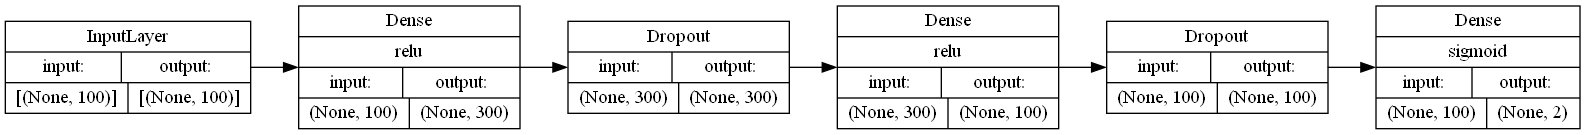

In [103]:
import pydot
import graphviz
plot_model(model, to_file='model_test.png', show_shapes=True, show_layer_names=False, show_layer_activations=True, rankdir="LR")

In [104]:
rep_dict = classification_report(Y_test_hot, predictions, output_dict=True)

print(pd.DataFrame(rep_dict).T.to_latex(bold_rows = True, float_format="%.2f" ))

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
\textbf{0           } &       0.76 &    0.78 &      0.77 &    41.00 \\
\textbf{1           } &       0.89 &    0.88 &      0.88 &    83.00 \\
\textbf{micro avg   } &       0.85 &    0.85 &      0.85 &   124.00 \\
\textbf{macro avg   } &       0.83 &    0.83 &      0.83 &   124.00 \\
\textbf{weighted avg} &       0.85 &    0.85 &      0.85 &   124.00 \\
\textbf{samples avg } &       0.85 &    0.85 &      0.85 &   124.00 \\
\bottomrule
\end{tabular}



C:\Users\crist\AppData\Local\Temp\ipykernel_2732\4095485670.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(rep_dict).T.to_latex(bold_rows = True, float_format="%.2f" ))
